In [41]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_decay import *

sim_name = f"no_gravity"
#! marias files are inside the Data/decay folder
decay_dir = f"Data/decay"
sim_folder = f"{decay_dir}/sim_output/{sim_name}"
fig_folder = f"{decay_dir}/figures_local/{sim_name}"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

z_int_steps = jnp.load(f"{sim_folder}/z_int_steps.npy")
s_int_steps = jnp.load(f"{sim_folder}/s_int_steps.npy")

save_dir = f"sim_output/no_gravity_decay_test"

# note: We must have realistic neutrino masses
m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.05*Params.eV, ordering="NO", args=Params())
print(m_light, m_mid, m_heavy)

def find_nearest(array, value):
    idx = jnp.argmin(jnp.abs(array - value))
    return idx, array[idx]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.05 0.05073657457889723 0.07080960386840193


## Pre-sim arrays analysis (from older functions)

In [2]:
Gamma_str ='2T'

angle_momentum_decay = jnp.load(
    f'{sim_folder}/neutrino_angle_momentum_decay.npy') 
decayed_neutrinos_theta = jnp.load(
    f'{sim_folder}/decayed_neutrinos_theta_{Gamma_str}.npy')
decayed_neutrinos_phi = jnp.load(
    f'{sim_folder}/decayed_neutrinos_phi_{Gamma_str}.npy')
decayed_neutrinos_z = jnp.load(
    f'{decay_dir}/decays_gamma/decayed_neutrinos_z_{Gamma_str}.npy')
decayed_neutrinos_index_z = jnp.load(
    f'{decay_dir}/decays_gamma/decayed_neutrinos_index_z_{Gamma_str}.npy', allow_pickle=True)
z_array = jnp.load(
    f'{sim_folder}/z_int_steps.npy')
neutrino_momenta = jnp.load(
    f'{sim_folder}/neutrino_momenta.npy')

common_args = (
    angle_momentum_decay, decayed_neutrinos_z, z_array, 
    neutrino_momenta,decayed_neutrinos_phi, decayed_neutrinos_theta)

ic(angle_momentum_decay.shape)
ic(decayed_neutrinos_theta.shape)
ic(decayed_neutrinos_phi.shape)
ic(decayed_neutrinos_z.shape)
ic(decayed_neutrinos_index_z.shape)
ic(z_array.shape)
ic(neutrino_momenta.shape)
print("END")

ic| angle_momentum_decay.shape: (180, 100)
ic| decayed_neutrinos_theta.shape: (334785,)
ic| decayed_neutrinos_phi.shape: (334785,)
ic| decayed_neutrinos_z.shape: (100, 768000)
ic| decayed_neutrinos_index_z.shape: (100,)
ic| z_array.shape: (100,)
ic| neutrino_momenta.shape: (1000,)


END


## Parent number density functions

(1000, 1000)
For Gamma=0.1 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.45e-03 (2.45e-03)

(1000, 1000)
For Gamma=0.5 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 7.59e+00 (7.59e+00)

(1000, 1000)
For Gamma=1.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.07e+01 (2.07e+01)

(1000, 1000)
For Gamma=2.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 3.43e+01 (3.43e+01)



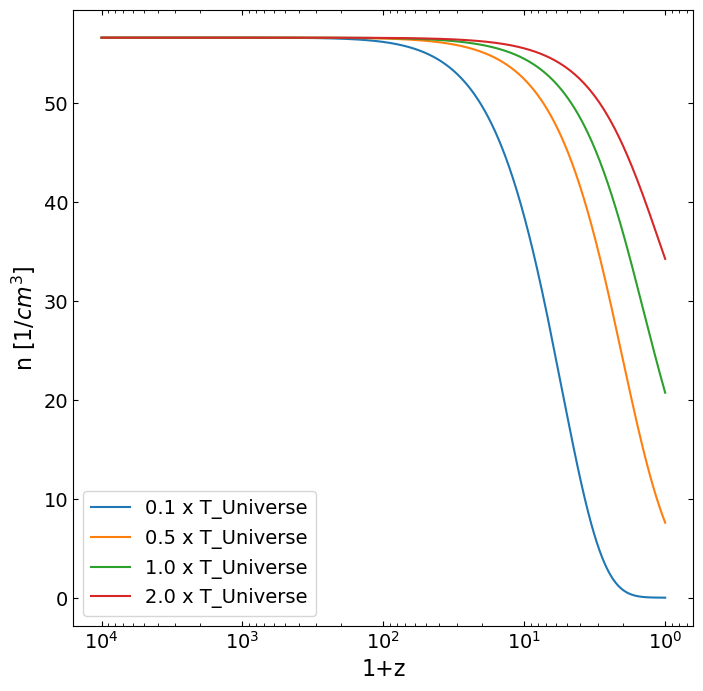

In [3]:
age_multipliers = [
    0.1, 
    0.5, 
    1., 
    2.
]

p_range = jnp.geomspace(0.01, 400, 1000)*Params.T_CNB
z_0, z_dec = 0., 10_000.
z_range = Utils.make_logz_arr(z_0, z_dec, 1000)

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    ### New functions ###
    redshifted_p = p_range[:, None]*(1+z_range)

    n3_raw, *_ = Decay.n3_p_range(
        p=redshifted_p, z=z_range, 
        Gamma=Gamma_val, m_h=m_heavy, args=Params())
    print(n3_raw.shape)
    n3_redshifts = trap(n3_raw*redshifted_p, x=jnp.log(redshifted_p), axis=0)

    # Print & plot results.
    cm3_unit = 1/Params.cm**3
    print(f"For Gamma={age_mult} x T_Universe, parent nr. density:")
    print(f"z_dec: {jnp.max(n3_redshifts)/cm3_unit:.2f} ({n3_redshifts[-1]/cm3_unit:.2f})")
    print(f"z_0: {jnp.min(n3_redshifts)/cm3_unit:.2e} ({n3_redshifts[0]/cm3_unit:.2e})\n")
    
    ax.semilogx(
        1+z_range, n3_redshifts/cm3_unit,
        label=f"{age_mult} x T_Universe")
    ax.set_xlabel('1+z')
    ax.set_ylabel(r'n [$1/cm^3$]')

# ax.set_xlim(0,4)
ax.invert_xaxis()
plt.legend()
plt.show()

## Inverse sampling

(768000,)
0.0 5196.039965347799
757441.0
(768000,)
0.0 3043.5373271518993
441374.0
(768000,)
0.0 2372.624528404399
267982.0
(768000,)
0.0 1832.5750549354661
148609.0


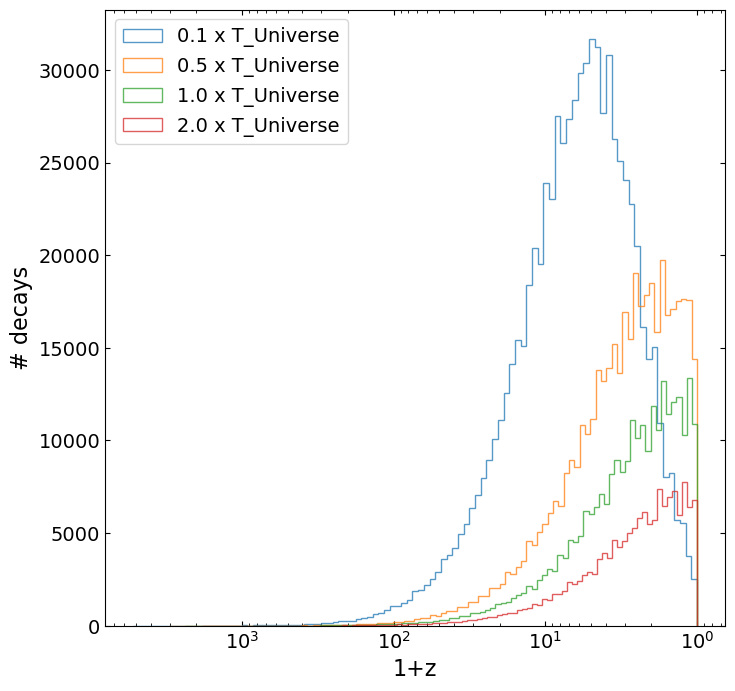

In [4]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)


histogram_data_l = []
for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    occurences_redshifts = Decay.montecarlo(
        z_range, p_range, m_heavy, simdata.nus_in_sim, Gamma_val, Params())
    print(occurences_redshifts.shape)
    print(occurences_redshifts.min(), occurences_redshifts.max())

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
        np.log10(np.min(1+occurences_redshifts)), 
        np.log10(np.max(1+occurences_redshifts)), 100)

    histogram_data, bins, _ = ax.hist(
        occurences_redshifts, bins=log_bins, histtype="step",
        alpha=0.75, label=f"{age_mult} x T_Universe")
    # has shape bins-1

    print(histogram_data.sum())
    histogram_data_l.append(histogram_data)

jnp.save(f"{save_dir}/histrogram_data.npy", jnp.array(histogram_data_l))

ax.set_xlabel("1+z")
ax.set_xscale("log")
ax.set_ylabel("# decays")
ax.invert_xaxis()
plt.legend()
plt.show()

## Generating pre-sim arrays

### Decay angles and momenta, as allowed by conservation laws

(10, 50, 2)
5 3.6032964613088203


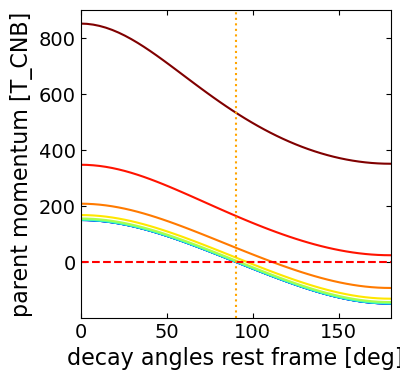

In [18]:
from scipy.optimize import fsolve
# note: Using numpy routines for fsolve compatibility


def rest_frame_quantities(m_h, m_l, m_phi):

    # Energies of daughter particles
    E_l = (m_h**2 + m_l**2 - m_phi**2) / (2*m_h)
    E_phi = (m_h**2 - m_l**2 + m_phi**2) / (2*m_h)

    # Momenta of daughter particles
    p_l = np.sqrt((m_h**2+m_l**2-m_phi**2)**2 - 4*m_h**2*m_l**2) / (2*m_h)
    p_phi = np.sqrt((m_h**2-m_l**2+m_phi**2)**2 - 4*m_h**2*m_phi**2) / (2*m_h)

    return E_l, p_l, E_phi, p_phi


# Rest frame (suscript 0) kinematics are completely fixed by masses
E_l_0, p_l_0, E_phi_0, p_phi_0 = rest_frame_quantities(m_h=m_heavy, m_l=m_light, m_phi=0.0)
# print(f"CHECK 1: ", np.isclose(p_l_0 - p_phi_0, [0.0]))
# print(f"CHECK 2: ", np.isclose(E_l_0 + E_phi_0, [m_heavy]))


def lab_frame_parent_momenta(p_h, p_l_z_target, angle, m_h, E_l_0, p_l_0):

    # Decay angle between axis of boost and p_l_0, i.e. momentum of daughter in rest frame
    # note: angle is defined via unit circle, so 0 deg is antiparallel,
    # note: we subtract pi, s.t. 0 deg corresponds to "straight line decay" in same direction
    cos_theta_0 = np.cos(np.deg2rad(angle) - np.pi)

    # Energy, velocity and Lorentz factor
    E_h = np.sqrt(p_h**2 + m_h**2)
    v_h = p_h/E_h
    gamma = 1/np.sqrt(1 - v_h**2)

    # Daughter momentum in lab frame
    p_l_z = gamma*(p_l_0*cos_theta_0 + v_h*E_l_0)

    # Return output as needed for fsolve to solve for it to become zero
    return p_l_z - p_l_z_target



common_args = (m_heavy, E_l_0, p_l_0)
p_num = 10  # target: p_num of sim = 1000 (or higher if needed, but base is 1k)
p_l_z_target_range = np.geomspace(0.01, 400, p_num)*Params.T_CNB
a_min = 0
a_max = 180
a_num = 50  # target: 1800
angles = np.linspace(a_min, a_max, a_num)

p_h_sol = np.empty((len(p_l_z_target_range), len(angles), 2))
for i, p_l_z_target in enumerate(p_l_z_target_range):
    
    for j, angle in enumerate(angles):
        p_h_fsolve = fsolve(
            func=lab_frame_parent_momenta, x0=p_l_z_target,
            args=(p_l_z_target, angle, *common_args))[0]
        
        #! If negative, decay angle is impossible with target daughter momentum
        # if p_h_fsolve < 0.0:
        #     p_h_fsolve = np.nan

        p_h_sol[i,j,0] = angle
        p_h_sol[i,j,1] = p_h_fsolve

print(p_h_sol.shape)
np.save(f"{sim_folder}/allowed_decay_angles_and_momenta_notebook.npy", p_h_sol)

p_l_select = 3.15*Params.T_CNB
idx, val = find_nearest(p_l_z_target_range, p_l_select)
print(idx, val/Params.T_CNB)


fig = plt.figure(figsize=(4,4))
fig.tight_layout()
ax = fig.add_subplot(111)

colors = plt.cm.jet(np.linspace(0, 1, p_num))
for c, p_h_set in enumerate(p_h_sol):

    ax.plot(p_h_set[..., 0], p_h_set[..., 1]/Params.T_CNB, color=colors[c])


ax.axhline(0.0, color="red", ls='dashed')
ax.axvline(90.0, color="orange", ls="dotted")
ax.set_xlabel(f"decay angles rest frame [deg]")
ax.set_ylabel(f"parent momentum [T_CNB]")
ax.set_xlim(a_min, a_max)  # normal
# ax.set_xlim(85, 95) ; ax.set_ylim(-0.5, 0.5)  # zoom-in
plt.show(); plt.close()

### Sampling from allowed regions

In [23]:
# TODO: steps to take (for now maybe not efficient/pretty)
# - for every target daughter momentum, compute angles from 0,180 with some resolution
# - sample only from allowed angles
# - with that angle, pick associated p_h and compute angle in lab frame
# - final arrays for sim usage should be:
#   - for each p_l have two sub-arrays with allowed angle and p_h pairs
#   - they should each have a high enough resolution for good accuracy
#   - so shape should be (p_sim_num, angle-p_h-reso, 2)
# - in simulation, when nu decays, we check it's momentum (p_l) and randomly pick a pair

# Momenta range as in sim, corresponding to daughter momenta
p_daughter_sim_range = np.geomspace(0.01, 400, 1000)*Params.T_CNB

# Load decay angles and momenta
decay_kinematics_data = jnp.load(f"{sim_folder}/allowed_decay_angles_and_momenta.npy")
decay_angles = decay_kinematics_data[..., 0]
parent_momenta = decay_kinematics_data[..., 1]
print(decay_angles.shape, parent_momenta.shape)

# Set all negative parent momenta to np.nan
parent_momenta = parent_momenta.at[parent_momenta <= 0.0].set(np.nan)
print(type(parent_momenta), parent_momenta.shape)

(1000, 1800) (1000, 1800)
<class 'jaxlib.xla_extension.ArrayImpl'> (1000, 1800)


### Indices, redshifts and angles

In [6]:
def decay_neutrinos(histogram_data, gamma_str, neutrinos, save_dir):

    # Create an array representing individual neutrinos (all ones)
    neutrinos_array = np.ones(neutrinos)

    # Lists to store decayed information for each redshift step
    decayed_redshift = []
    neutrinos_decayed_index = []
    neutrinos_decayed_theta = []
    neutrinos_decayed_phi = []

    # Track remaining neutrino indices
    remaining_indices = np.arange(neutrinos)
    
    # Iterate over redshift steps
    for num_decayed in histogram_data:
        
        # Randomly select neutrinos to decay without replacement
        selected_indices = np.random.choice(remaining_indices, size=num_decayed, replace=False)
        
        # Remove selected indices from remaining indices
        remaining_indices = np.setdiff1d(remaining_indices, selected_indices)
        
        # Generate random angles
        thetas = np.random.randint(0, 180, size=num_decayed)
        phis = np.random.randint(0, 360, size=num_decayed)
        
        # Append and store values
        neutrinos_decayed_index.append(selected_indices)
        neutrinos_decayed_theta.extend(thetas)
        neutrinos_decayed_phi.extend(phis)
        
        # Update neutrinos_array to reflect decayed neutrinos
        neutrinos_array[selected_indices] = 0
        decayed_redshift.append(np.copy(neutrinos_array))

    # One check if part of routine worked
    print(len(remaining_indices))
    print(neutrinos - histogram_data.sum())
    
    # Save the results
    neutrinos_decayed_index_array = np.array(neutrinos_decayed_index, dtype=object)
    np.save(f'{save_dir}/decayed_neutrinos_index_z_{gamma_str}.npy', neutrinos_decayed_index_array)
    np.save(f'{save_dir}/decayed_neutrinos_z_{gamma_str}.npy', decayed_redshift)
    np.save(f'{save_dir}/decayed_neutrinos_theta_{gamma_str}.npy', neutrinos_decayed_theta)
    np.save(f'{save_dir}/decayed_neutrinos_phi_{gamma_str}.npy', neutrinos_decayed_phi)

    print(np.array(decayed_redshift).shape)


gamma_strings = [
    "0.1T",
    "0.5T",
    "1T",
    "2T",
]

hist_data_arr = np.load(f"{save_dir}/histrogram_data.npy").astype(int)
for hist_data, g_str in zip(hist_data_arr, gamma_strings):

    decay_neutrinos(
        histogram_data=hist_data, gamma_str=g_str, 
        neutrinos=simdata.nus_in_sim, save_dir=save_dir)


10559
10559
(99, 768000)
326626
326626
(99, 768000)
500018
500018
(99, 768000)
619391
619391
(99, 768000)


## EOMs_no_gravity routine (work in progress...)